In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
%pylab inline
#pylab.rcParams['figure.figsize'] = (10, 8)
plt.style.use(['ggplot'])

import os
from dtw import dtw
import pandas as pd
import pickle


cwd = os.getcwd()
print (cwd)
# import mlpy

Populating the interactive namespace from numpy and matplotlib
/accounts/grad/jorothy_gong/MyShakeAnalysis/code/Yun


In [2]:
import random
from obspy.signal.trigger import classic_sta_lta
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, precision_recall_fscore_support

In [3]:
def get_data(data):
    '''
    helper function to get the timestamp and 3-component acceleration data. 
    '''
    # read in x, y, z data
    x = data['data']['x']
    y = data['data']['y']
    z = data['data']['z']

    # calculate the timestamp
    # get the start time
    t0 = data['header']['starttime']
    npoints = len(x)
    sampling_rate = data['header']['sampling_rate']
    
    # get the end time 
    t1 = t0 + npoints / sampling_rate
    
    # form the timestamp
    t = [t0 + tmp/sampling_rate for tmp in range(0, npoints)]
    
    # station latitude and long
    return t, x, y, z

def plot_data(t, x, y, z):
    '''
    helper function to plot the 3-component acceleration data
    '''
    figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(311)
    plt.plot(t, x)
    plt.subplot(312)
    plt.plot(t, y)
    plt.ylabel('Acceleration (g)')
    plt.subplot(313)
    plt.plot(t, z)
    plt.xlabel('Time (sec)')
    plt.show()

## Dynamic Time Warping

In [4]:
def Normalize_Seq(seq_x = None, seq_y = None, seq_z = None, dim = 3):
    """
    May need further normalization later.
    Take either 1-dim accelaretion sequence or 3-dim, or 2-idm.
    """
    tmp = []
    if seq_x != None:
        seq_x = seq_x - np.mean(seq_x)
        tmp.append(seq_x)
    if seq_y != None:
        seq_y = seq_y - np.mean(seq_y)
        tmp.append(seq_y)
    if seq_z != None:
        seq_z = seq_z - np.mean(seq_z)
        tmp.append(seq_z)
        
    if dim != 3:
        return tmp
    else:
        return seq_x, seq_y, seq_z

In [5]:
def MyDistance(x, y):
    return (x * x) + (y * y)

def Cal_DTW(x, y, fun = None):
    #print('ha')
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).reshape(-1, 1)
    if fun == None:
        dist, cost, acc, path = dtw(x, y, dist = lambda x, y: norm(x - y, ord=1))
    else:
        dist, cost, acc, path = dtw(x, y, dist = fun)
        
    return dist

# Cal_DTW_Compare
def DTW_Self(seq, window = 2, interval = 0.5, gap = 1/5, rate = 25):
    """
    Now sequence is only 1-dim accelaration sequence.
    Add if sequence length < 5 seconds
    """
    seq = seq - np.mean(seq)
    seq_len = len(seq)
    seq_win = int(window * rate)
    seq_int = int(interval * rate)
    compute_gap = int(gap * rate)
    return [Cal_DTW(seq[i : (i + seq_win)], seq[(i + seq_int) : (i + seq_win + seq_int)]) 
            for i in range(0, seq_len - seq_win - seq_int, compute_gap)]

## Aggregate Data for Random Forest

In [6]:
# Cal_DTW_Compare
def DTW_Self(seq, window = 2, interval = 1, gap = 1, rate = 25):
    """
    Now sequence is only 1-dim accelaration sequence.
    Add if sequence length < 5 seconds
    """
    seq = seq - np.mean(seq)
    seq_len = len(seq)
    seq_win = int(window * rate)
    seq_int = int(interval * rate)
    compute_gap = int(gap * rate)
    return [Cal_DTW(seq[i : (i + seq_win)], seq[(i + seq_int) : (i + seq_win + seq_int)]) 
            for i in range(0, seq_len - seq_win - seq_int, compute_gap)]
 

In [7]:
from obspy.signal.trigger import classic_sta_lta
# from obspy.signal.trigger import z_detect
# cft = z_detect(x, int(10 * rate))
# from obspy.signal.trigger import plot_trigger

data = json.load(open('../../data/EQ/simulated/FHO_M5.1_1396066187.json', 'r'))


def get_data2(data, group = 'simulated', plot_trigger = False,
              window = 2, interval = 1, gap = 1, rate = 25, threshold_sta_lta = 1.5):
    """
    1.How to define trigger in the sta_lta need to be discussed, the threshold = 1.5 may not be good for Human, 
    though sounds plausible. involve variance median mean? tuning short/long time as 2/10 seconds
    2.thus in future aggregating data may be different for human and EQ
    3.when design features in the future, window and gap here can be set coincide with the windows used in features
    """
    if group == 'simulated':
        t, x, y, z = get_data(data)
        rate = data['header']['sampling_rate']
        x, y, z = Normalize_Seq(x, y, z)
        #print(len(x),len(y),len(z),len(t),rate)
        length = min(len(x),len(y),len(z),len(t))
        ## window, gap
        predictor = [[x[i],y[i],z[i]] for i in range(length)]
        cft_x = classic_sta_lta(x[:length], int(2 * rate), int(10 * rate))
        cft_y = classic_sta_lta(y[:length], int(2 * rate), int(10 * rate))
        cft_z = classic_sta_lta(z[:length], int(2 * rate), int(10 * rate))
        response = ((cft_x > threshold_sta_lta)*1 * (cft_y > threshold_sta_lta)*1 * (cft_z > threshold_sta_lta)*1)

    elif group == 'shake_table':
        t, x, y, z = get_data(data)
        rate = data['header']['sampling_rate']
        x, y, z = Normalize_Seq(x, y, z)
        #print(len(x),len(y),len(z),len(t),rate)
        length = min(len(x),len(y),len(z),len(t))
        ## window gap
        predictor = [[x[i],y[i],z[i]] for i in range(length)]
        cft_x = classic_sta_lta(x[:length], int(2 * rate), int(10 * rate))
        cft_y = classic_sta_lta(y[:length], int(2 * rate), int(10 * rate))
        cft_z = classic_sta_lta(z[:length], int(2 * rate), int(10 * rate))
        response = ((cft_x > threshold_sta_lta)*1 * (cft_y > threshold_sta_lta)*1 * (cft_z > threshold_sta_lta)*1)

    # [i/25 for i,x in enumerate(response) if x ==1]
    elif group == 'human':
        t, x, y, z = get_data(data)
        rate = data['header']['sampling_rate']
        x, y, z = Normalize_Seq(x, y, z)
        #print(len(x),len(y),len(z),len(t),rate)
        length = min(len(x),len(y),len(z),len(t))
        ## window gap
        predictor = [[x[i],y[i],z[i]] for i in range(length)]
        cft_x = classic_sta_lta(x[:length], int(2 * rate), int(10 * rate))
        cft_y = classic_sta_lta(y[:length], int(2 * rate), int(10 * rate))
        cft_z = classic_sta_lta(z[:length], int(2 * rate), int(10 * rate))
        #response = ((cft_x > threshold_sta_lta)*1 * (cft_y > threshold_sta_lta)*1 * (cft_z > threshold_sta_lta)*1)
        response = [0 for i in range(length)]
        
    if plot_trigger:
        plot_data(t, x, y, z)
        plt.plot(cft_x)
        plt.plot(cft_y)
        plt.plot(cft_z)
        plt.axhline(y=threshold_sta_lta, color='black')
        
        
    return predictor, response
        
    

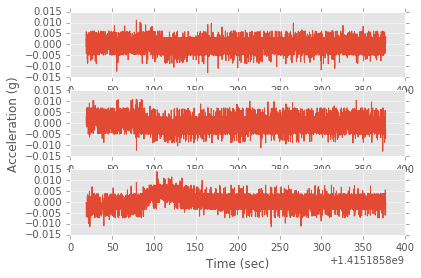

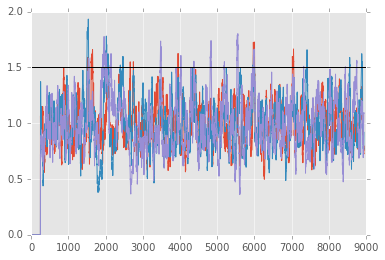

In [8]:
data = json.load(open('../../data/Human/013306004148017_1415185819.json', 'r'))
predictor, response = get_data2(data, group = 'human', plot_trigger=True)
# [i/25 for i,x in enumerate(response) if x ==1]

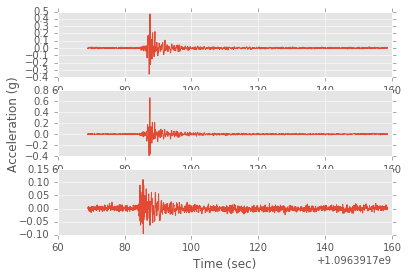

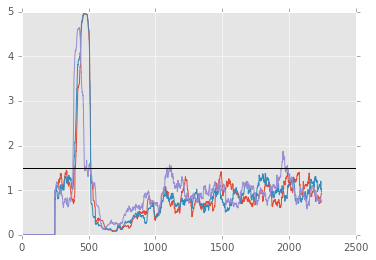

In [9]:
data = json.load(open('../../data/EQ/simulated/36668_M6.0_1096391769.json', 'r'))
predictor, response = get_data2(data, group = 'simulated', plot_trigger=True)

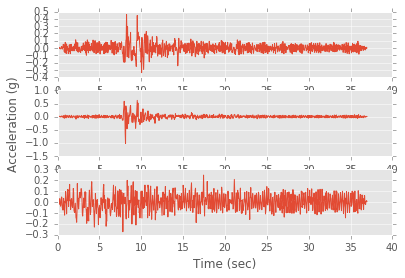

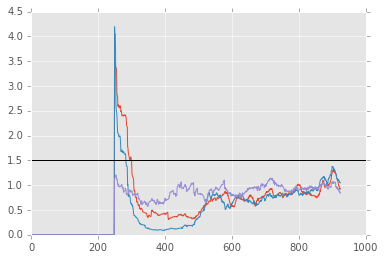

In [10]:
data = json.load(open('../../data/EQ/shake_table/trial61_phone1.json', 'r'))
predictor, response = get_data2(data, group = 'shake_table', plot_trigger=True)

In [13]:
path_to_json = cwd + '/../../data/EQ/shake_table/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(len(json_files))
json_files_shake = json_files

path_to_json = cwd + '/../../data/EQ/simulated/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(len(json_files))
json_files_simulated = json_files

path_to_json = cwd + '/../../data/Human/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(len(json_files))
json_files_human = json_files[:5000]

####
# json_files = json_files_shake + json_files_simulated + json_files_human
path_to_json = cwd + '/../../data/EQ/shake_table/'
json_files = json_files_shake

192
992
26343


In [14]:
X = []
Y = []

for js in json_files:
    #print(js)
    with open(path_to_json+js) as infile:
        data = json.load(infile)
    
    predictor, response = get_data2(data, group = 'shake_table', plot_trigger=False)
    #print(len(predictor) == len(response))
    X.extend(predictor)
    Y.extend(response)
    #Y = np.append(Y,response)
    
X = np.asarray(X)
Y = np.asarray(Y)

n_train = int(len(X)*0.5)
n_test = int(len(X)*0.4)

X_train = X[:n_train]
Y_train = Y[:n_train]

X_valid= X[n_train:-n_test]
Y_valid = Y[n_train:-n_test]

X_test = X[-n_test:]
Y_test = Y[-n_test:]
# with open(path_to_json + 'DTW_shake.json', 'w') as f:
#     json.dump(DTW, f, indent=None, sort_keys=False)

In [15]:
# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, Y_train)

clf_label = clf.predict(X_test)
precision_recall_fscore_support(Y_test,clf_label)



(array([ 0.94900513,  0.53287381]),
 array([ 0.98704183,  0.21795706]),
 array([ 0.96764984,  0.30937356]),
 array([67988,  4611]))

In [16]:
clf_probs = clf.predict_proba(X_test)
score = log_loss(Y_test, clf_probs)
score


0.53549708047119704

In [17]:
# Train random forest classifier, calibrate on validation data and evaluate on test data
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(X_valid, Y_valid)

sig_clf_probs = sig_clf.predict_proba(X_test)
sig_score = log_loss(Y_test, sig_clf_probs)
sig_score

0.18750569937707273

## Incorporate all : DTW, sta-lta, 

In [65]:
f1 = open('data1.pckl', 'rb')
f0 = open('data0.pckl', 'rb')
data1 = pickle.load(f1)
data0 = pickle.load(f0)
f1.close()
f0.close()

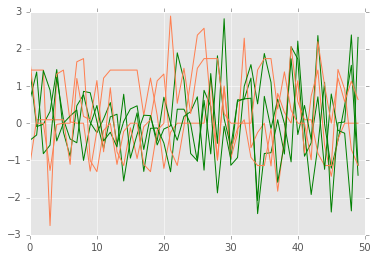

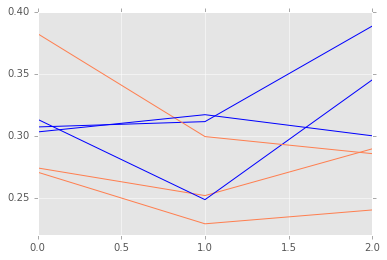

In [172]:
## Visualize DTW for x,y,z
row = 0
for i in np.linspace(0,100,3,dtype=int):
    plt.plot(data1[row,:-1][i:(i+50)], color = 'green')
    plt.plot(data0[row,:-1][i:(i+50)], color = 'coral')
plt.show()
    
for i in np.linspace(0,100,3,dtype=int):
    plt.plot(DTW_Self(seq = data1[row,:-1][i:(i+50)], 
                      window = 25/25, interval = 10/25, gap = 5/25, rate = 25), color = 'blue')
    plt.plot(DTW_Self(seq = data0[row,:-1][i:(i+50)], 
                      window = 25/25, interval = 10/25, gap = 5/25, rate = 25), color = 'coral')
plt.show()

In [138]:
# row = 0
# for i in np.linspace(0,100,3,dtype=int):
#     print(DTW_Self(seq = data1[row,:-1][i:(i+50)], window = 25/25, interval = 10/25, gap = 5/25, rate = 25))
#     #DTW_Self(seq = data0[row,:-1][i:(i+50)], window = 25/25, interval = 10/25, gap = 5/25, rate = 25)
    
#pd.DataFrame(np.append(a,np.var(a)).reshape(1,-1))

#classic_sta_lta(z[:length], int(2 * rate), int(10 * rate))

[0.30698776635598696, 0.31127580048710685, 0.38839435939516187]
[0.31315431949622818, 0.24834142544205853, 0.34503182268919685]
[0.30295017003444524, 0.31686284407690041, 0.29982140745885233]


In [204]:
b = [np.array([DTW_Self(seq = data1[row,:-1][i:(i+50)], window = 25/25, interval = 10/25, gap = 5/25, rate = 25) 
              for i in np.linspace(0,100,3,dtype=int)]).ravel() for row in range(len(data1))]
b = np.asarray(b)

In [209]:
dtw1 = np.hstack((np.ones(len(b)).reshape(-1,1),np.var(b,axis=1).reshape(-1,1)))

In [214]:
b = [np.array([DTW_Self(seq = data0[row,:-1][i:(i+50)], window = 25/25, interval = 10/25, gap = 5/25, rate = 25) 
              for i in np.linspace(0,100,3,dtype=int)]).ravel() for row in range(len(data0[:2000]))]
b = np.asarray(b)

In [261]:
dtw0 = np.hstack((np.zeros(len(b)).reshape(-1,1),b,np.var(b,axis=1).reshape(-1,1)))

In [313]:
YX = np.vstack((dtw1,dtw0))
X = YX[:,1:]
Y = YX[:,0]

In [314]:
idx_permute = np.random.choice(len(YX),replace=False,size=len(YX))
n_train = int(len(YX)*0.4)
n_test = int(len(YX)*0.4)
n_valid = len(YX) - n_train - n_test

idx_train = idx_permute[:n_train]
idx_valid = idx_permute[n_train:-n_test]
idx_test = idx_permute[-n_test:]

In [316]:
X_train = X[idx_train,:]
Y_train = Y[idx_train]

X_valid = X[idx_valid,:]
Y_valid = Y[idx_valid]

X_test = X[idx_test,:]
Y_test = Y[idx_test]

In [342]:
# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
clf = RandomForestClassifier(n_estimators=25,max_depth=None)
clf.fit(X_train, Y_train)

clf_label = clf.predict(X_test)
print(sum(clf_label == Y_test) / len(Y_test))
precision_recall_fscore_support(Y_test,clf_label)

0.771294433266


(array([ 0.78424242,  0.75525526]),
 array([ 0.79876543,  0.73861968]),
 array([ 0.79143731,  0.74684484]),
 array([810, 681]))

In [343]:
clf.feature_importances_

array([ 0.15791069,  0.07105351,  0.07254467,  0.15174602,  0.0706116 ,
        0.07334051,  0.08717834,  0.07054417,  0.11652967,  0.12854082])

In [322]:
clf_probs = clf.predict_proba(X_test)
score = log_loss(Y_test, clf_probs)
score

0.48907558652885935

In [323]:
# Train random forest classifier, calibrate on validation data and evaluate on test data
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(X_valid, Y_valid)

sig_clf_probs = sig_clf.predict_proba(X_test)
sig_score = log_loss(Y_test, sig_clf_probs)
sig_score

0.45249028813856335

## Manifold Learning

In [18]:
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

In [115]:
# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

In [103]:
f1 = open('data1.pckl', 'rb')
f0 = open('data0.pckl', 'rb')
data1 = pickle.load(f1)
data0 = pickle.load(f0)
f1.close()
f0.close()

In [104]:
fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

In [126]:
len0 = 1000
len1 = 1000
X = np.append(data0[:len0,:-1],data1[:len1,:-1],axis=0)
color = ['coral']*len0 + ['green']*len1

SpectralEmbedding: 3.5 sec


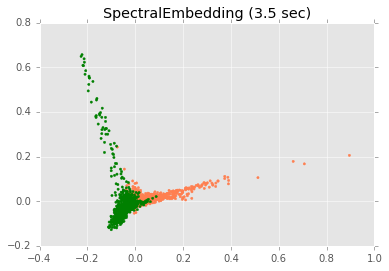

SpectralEmbedding: 0.88 sec


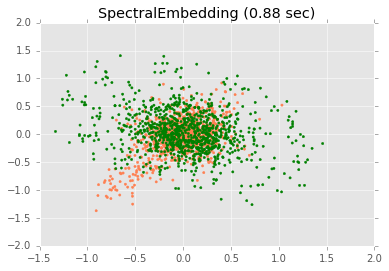

In [127]:
t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors,
                                affinity='nearest_neighbors')
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], marker = '.',
            color = color, cmap=plt.cm.Spectral)
# [int(i<300) for i in range(X.shape[0])]
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
plt.show()


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors,
                                affinity='rbf')
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], marker = '.',
            color = color, cmap=plt.cm.Spectral)
# [int(i<300) for i in range(X.shape[0])]
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
plt.show()

Isomap: 3.3 sec


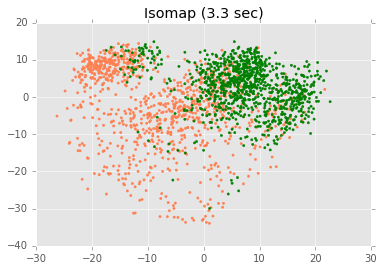

In [128]:
t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:, 0], Y[:, 1], marker = '.',
            color = color, cmap=plt.cm.Spectral)
# [int(i<300) for i in range(X.shape[0])]
plt.title("Isomap (%.2g sec)" % (t1 - t0))
plt.show()

MDS: 8.5 sec


(-18.308645230800298,
 18.276308633068155,
 -17.802741249545477,
 18.229456015432611)

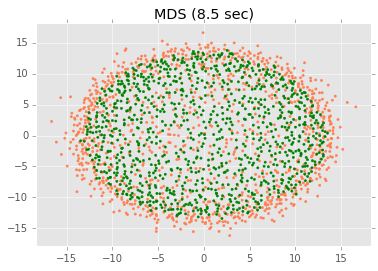

In [130]:
t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y[:, 0], Y[:, 1], marker = '.',
            color = color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
plt.show()

t-SNE: 9.9 sec


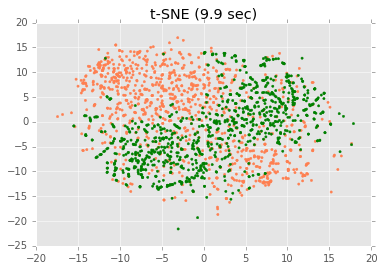

t-SNE: 13 sec


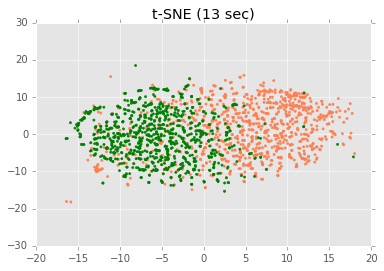

In [134]:
t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1],  marker = '.',
            color = color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
plt.show()

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='random', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1],  marker = '.',
            color = color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
plt.show()

In [124]:
try:
    # compatibility matplotlib < 1.0
    ax = fig.add_subplot(251, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=['coral']*len0 + ['green']*len1, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)
except:
    ax = fig.add_subplot(251, projection='3d')
    plt.scatter(X[:, 0], X[:, 2], c=['coral']*len0 + ['green']*len1, cmap=plt.cm.Spectral)

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

standard: 3.5 sec


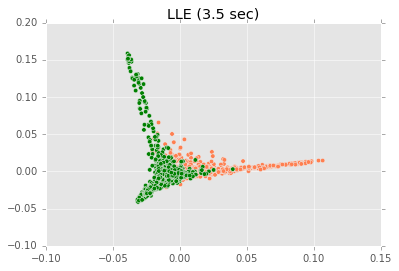

/usr/local/linux/anaconda3/lib/python3.5/site-packages/scipy/linalg/decomp_lu.py:71: RuntimeWarning: Diagonal number 26 is exactly zero. Singular matrix.
  RuntimeWarning)


ltsa: 1.8 sec


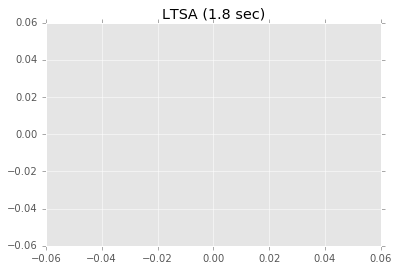

ValueError: Error in determining null-space with ARPACK. Error message: 'Factor is exactly singular'. Note that method='arpack' can fail when the weight matrix is singular or otherwise ill-behaved.  method='dense' is recommended. See online documentation for more information.

In [125]:
for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=['coral']*len0 + ['green']*len1, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    plt.show()